# Import the data from xlsx 

In [28]:
import openpyxl
import datetime
# Open the workbook and select the first worksheet
wb = openpyxl.load_workbook('wordle_data.xlsx')
sh = wb['Sheet1']
# List to hold dates
date_list = []
word_list = []
normal_people_list = []
hard_people_list = []
overall_percent_list = []

#Iterate through each row in worksheet and fetch values into dict
#value starts at row 3

for row in range(3, sh.max_row + 1):
    # Each row in the spreadsheet has data for one date
	date = sh.cell(row=row, column=1).value
	# if the date is none, then break the loop
	if date is None:
		break
	word = sh.cell(row=row, column=3).value
	normal_people = sh.cell(row=row, column=4).value
	hard_people = sh.cell(row=row, column=5).value
	# F to L as a list, then append the list to overall_percent_list
	daily_percent = [sh.cell(row=row, column=i).value for i in range(6, 12)]
	

	# Append the date and value to the appropriate list
	# Convert the date string into a datetime object.
	date = datetime.datetime.strptime(date, "%m/%d/%Y")
	date_list.append(date)
	word_list.append(word)
	normal_people_list.append(normal_people)
	hard_people_list.append(hard_people)
	overall_percent_list.append(daily_percent)
 
# inverse all lists into chronological order
date_list.reverse()
word_list.reverse()
normal_people_list.reverse()
hard_people_list.reverse()
overall_percent_list.reverse()




# Data Preprocessing

In [32]:
import numpy as np

normal_people_array = np.array(normal_people_list).astype(float)
hard_people_array = np.array(hard_people_list).astype(float)

# z-scores
normal_zscores = (normal_people_array - np.mean(normal_people_array)) / np.std(normal_people_array)
hard_zscores = (hard_people_array - np.mean(hard_people_array)) / np.std(hard_people_array)

# Detect every noisy point with threshold of 3 in normal_people_array and hard_people_array
threshold = 3
normal_outliers = np.where(np.abs(normal_zscores) > threshold)
hard_outliers = np.where(np.abs(hard_zscores) > threshold)


# Apply moving average to smooth noisy points
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')



window_size = 12 # todo: find the best window size
smoothed_normal_people_list  = moving_average(normal_people_array, window_size)
smoothed_hard_people_list = moving_average(hard_people_array, window_size)


#todo: evaluate the performance



In [44]:
# logistic curve fitting 
# todo: 效果非常不好
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=0) # 'newton-cg', 'lbfgs', 'sag', and 'saga'.
# 'liblinear' solver doesn’t work without regularization.
# 'newton-cg', 'sag', 'saga', and 'lbfgs' don’t support L1 regularization.
# 'saga' is the only solver that supports elastic-net regularization.

# convert date_list to integer
date_index = np.array([int(date.timestamp()) for date in date_list]).reshape(-1, 1)
# March 1st, 2022 as an interger

model.fit(date_index, np.array(normal_people_list).astype(float))
print(model.score(date_index, np.array(normal_people_list).astype(float)))
x_pred = np.array([int(datetime.datetime(2022, 3, 1).timestamp())]).reshape(-1, 1)
y_pred = model.predict(x_pred)
print(y_pred)
# # Plot the data and the curve fit
# plt.plot(date_list, smoothed_normal_people_list, 'bo', label='Data')
# plt.plot(x_pred, y_pred, 'r-', label='Logistic Function Fit')
# plt.legend()
# plt.show()



0.00558659217877095
[36223.]


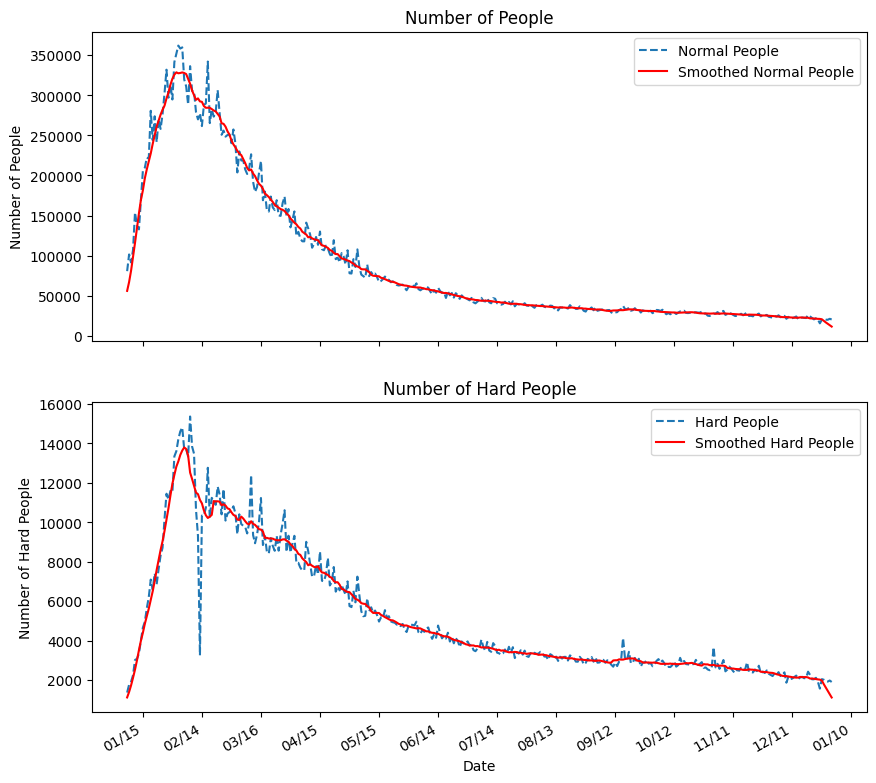

In [34]:

# Plot the data for comparison in two graphs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# # Plot the data of normal people and hard people
ax1.plot(date_list, normal_people_array, '--', label='Normal People')
ax1.plot(date_list, smoothed_normal_people_list, 'r', label='Smoothed Normal People')
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax1.xaxis.set_tick_params(rotation=120)
ax1.set_title('Number of People')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of People')
ax1.legend()

# # Plot the smoothed data of normal people and hard people
ax2.plot(date_list, hard_people_array,'--', label='Hard People')
ax2.plot(date_list, smoothed_hard_people_list,'r', label='Smoothed Hard People')
ax2.set_title('Number of Hard People')
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax2.xaxis.set_tick_params(rotation=120)
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Hard People')
ax2.legend()


# # Format the x-axis for dates (label formatting, rotation)
fig.autofmt_xdate()

# # Show the plot
plt.show()

# Todo

In [76]:
# calculate the difficulty of each word
D_list = [] # key: word, value: difficulty

for i in range(len(word_list)):
	word = word_list[i]
	D_coefficient = (1 * overall_percent_list[i][0] + 2 * overall_percent_list[i][1] + 3 * overall_percent_list[i][2] + 4 * overall_percent_list[i][3] + 5 * overall_percent_list[i][4] + 6 * overall_percent_list[i][5] + 7 * overall_percent_list[i][6])/100
	D_list.append(D_coefficient)

# Random forest model
Predict number of participants

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [17]:
import datetime

# Set the reference date
ref_date = datetime.date(2022, 1, 1)

# Convert the dates to datetime objects
date_list = [datetime.datetime.strptime(date_str, '%Y-%m-%d').date() for date_str in date_list_str]

# Calculate the number of days since the reference date
date_list_float = [(date - ref_date).days for date in date_list]


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate model performance
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) #  Calculate mean squared error
print('R-squared:', r2_score(y_test, y_pred))



NameError: name 'date_list_str' is not defined

ValueError: x and y must be the same size

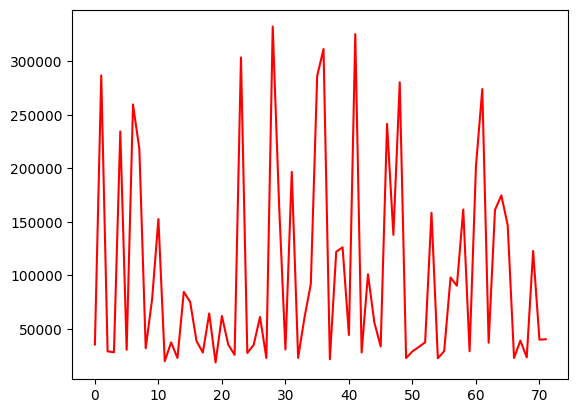

In [ ]:
# Plot the predicted values as a red line
plt.plot(y_pred, color='red', label='Predicted')

# Plot the actual values as blue scatter points
plt.scatter(X_test, y_test, color='blue', label='Actual')

plt.xlabel('Instance')
plt.ylabel('Participants')
plt.title('Actual vs. Predicted(Test Data)')
plt.legend()
plt.show()

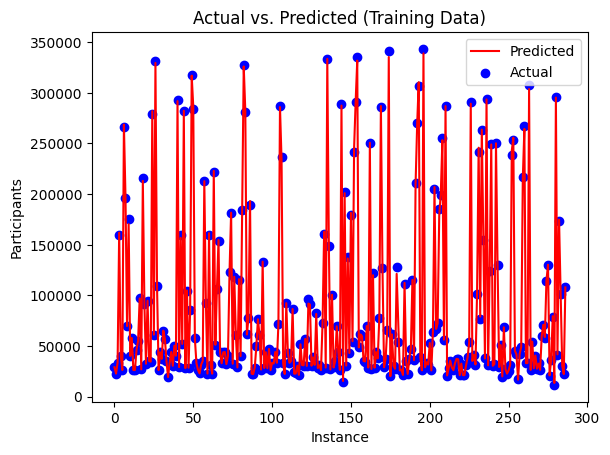

In [ ]:
# Make predictions on the training data
y_pred_train = rf.predict(X_train)

# Plot the predicted values as a red line
plt.plot(y_pred_train, color='red', label='Predicted')

# Plot the actual values as blue scatter points
plt.scatter(range(len(y_train)), y_train, color='blue', label='Actual')

plt.xlabel('Instance')
plt.ylabel('Participants')
plt.title('Actual vs. Predicted (Training Data)')
plt.legend()
plt.show()


# Predict March 1st 2023

ValueError: X has 3 features, but RandomForestRegressor is expecting 2 features as input.